**Import Dependencies**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import signal
import scipy.io.wavfile
import scipy.signal
from scipy.signal import butter, iirnotch, lfilter
from sys import breakpointhook
import math

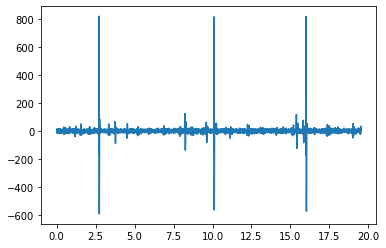

5000


In [ ]:
plotted = []
xaxis = []
myfile = open("Data.txt", "r")
for k in range(0,78125,1):
    y = k/256  
    s = float(myfile.readline())
    xaxis.append(s)
for k in range(30000,35000,1):
    plotted.append(xaxis[k])
y = np.arange(len(plotted))/256    
plt.plot(y, plotted)
plt.show()
print(len(plotted))

In [ ]:
def notch_filter(cutoff, q):
    nyq = 0.5*256
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a 

def bandpass(lowcut, highcut, order=5):
    nyq = 0.5 * 256
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

**Needle EMG Decomposition Function**

In [ ]:
def EMG_Decomposition(xaxis, T):
    plotted=[]
    for k in range(30000,35000,1):
        plotted.append(xaxis[k])
    y = np.arange(len(plotted))/256
    #Notch filter
    b,a = notch_filter(50,30)
    filteredBand = scipy.signal.filtfilt(b, a, plotted)


    #Bandpass filter
    bb, aa = bandpass(0.1, 45, order=5)
    filteredBandPass = scipy.signal.filtfilt(bb, aa, filteredBand)
    plotted3 = []
    for k in range(0,len(filteredBandPass)-1,1):
        plotted3.append(filteredBandPass[k])
    y3 = np.arange(len(plotted3))/256 
    
    
    #Rectified Signal
    temp2 = [];
    unfiltered = []
    for k in range(0,len(filteredBandPass),1):
        temp2.append(abs(filteredBandPass[k]))
    for k in range(0,len(xaxis),1):
        unfiltered.append(abs(xaxis[k]))    
    plotted5 = []
    for k in range(0,len(temp2),1):
        plotted5.append(temp2[k])
    y5 = np.arange(len(plotted5))/256  
    

    #Moving average with size N
    temp3 = []
    for k in range(0,len(temp2),1):
        N1 = k
        NN = T
        sum = 0
        while(NN > 0):
            sum += temp2[N1]
            N1 = N1-1
            NN = NN -1
        avg = (1/T) * sum  
        temp3.append(avg)
    
    plotted6 = []
    for k in range(0,len(temp3),1):
        plotted6.append(temp3[k])
    y6 = np.arange(len(plotted6))/256
    
    #Noise Threshold
    noise = []    
    for k in range(0,100,1):
        noise.append(temp2[k])
    arr = np.array([noise])   
    thresh = 3 * np.std(unfiltered[0:126])    
    
    #Detecting MUAPs
    step = 0
    plotted7 = []  
    breaked = False
    k = 0
    index = []
    while(k < len(plotted6)-T):
        if(plotted6[k] > thresh):
            step = k + 1
            S = step+T
            while(step < S):
                if(plotted6[step] < thresh):
                    breaked = True
                    break
                else:   
                    step = step + 1
            if(breaked == False):
                plotted7.append(plotted6[k])
                index.append(y3[k])
                k = k + T
            else:
                breaked = False
        k = k + 1 
    
    
    #Updating Templates
    N = 0
    Templates = []
    TemplatesMax = []
    first = []
    second = []
    peaks = []
    for k in range(0, len(y3),1):
        if(y3[k] == index[0]):
            first.append(y3[k])
            TemplatesMax.append(plotted3[k:k+T])
            max = np.max(TemplatesMax[0])
            peaks.append(max)
            for i in range(0, len(plotted3), 1):
                if(plotted3[i] == max):
                    Templates.append(plotted3[i-10:i+10])
    Temp = []
    Updated = []
    third = []
    Belongs = False
    for k in range(0, len(y3),1):
        for i in range(1, len(index), 1):
            if(y3[k] == index[i]):
                c = k
                TemplatesMax = []
                TemplatesMax.append(plotted3[k:k+T])
                max = np.max(TemplatesMax[0])
                for i in range(0, len(plotted3), 1):
                    if(plotted3[i] == max):
                        peaks.append(max)
                        Temp.append(plotted3[i-10:i+10])
                for i in range(0, len(Templates), 1):
                    cc = i
                    diff = np.subtract(Temp[0], Templates[i])**2
                    sums = np.sum(diff)
                    if(sums < ((12.65)**5)):
                        if(i == 0):
                            first.append(y3[c])
                        if(i == 1):
                            second.append(y3[c]) 
                        Belongs = True
                        avg = (np.array(Temp[0]) + np.array(Templates[i])) / 2.0

                        break          
                if(Belongs == False):
                    second.append(y3[c]) 
                    TemplatesMax.append(plotted3[k:k+T])
                    max = np.max(TemplatesMax[0])
                    for i in range(0, len(plotted3), 1):
                        if(plotted3[i] == max):
                            Templates.append(plotted3[i-10:i+10])
                else:
                    Belongs = False
                Temp = []


    plt.figure(figsize=(20,10)) 
    plt.subplot(1,3,1)
    plt.title("Template 1")
    plt.plot(Templates[0], color = 'b')
    plt.subplot(1,3,2)
    plt.title("Template 2")
    plt.plot(Templates[1], color = 'r')
    plt.subplot(1,3,3)
    plt.title("Detected MUAPs")
    plt.plot(y3, plotted3)
    plt.scatter(first, np.ones(len(first))*600, s=50,c = [0,0,1], marker='*')  
    plt.scatter(second, np.ones(len(second))*600, s=50,color = 'r', marker='*')
    # plt.savefig('/content/gdrive/MyDrive/Semester 10/Biomedical/Biomedical Assignment 2/Templates.jpg')
    # plt.savefig('/content/gdrive/MyDrive/Semester 10/Biomedical/Biomedical Assignment 2/DetectedMUAP.jpg')
    
    
    return peaks, Templates

**Running and calling the function**

---



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[40.878083961781485, 644.3967133095849, 52.91440676232776, 67.63204708653838, 123.52310462563004, 62.30096638586955, 630.9519605009059, 47.790350929021216, 113.23074373789295, 39.46418294814699, 66.73345664052572, 637.3673880389773, 42.78996650167413, 37.47081656855484]
[[-6.347340428526484, -3.1970088919057806, -7.502424520802548, -16.638171136890627, -25.076798575301346, -27.030611823157674, -19.120847316018803, -2.235483318866572, 18.307361597573205, 34.80196997681032, 40.878083961781485, 34.98156728963823, 21.229500098538164, 6.7860628129511875, -2.5908066589893037, -5.793265260814113, -6.114934453007831, -7.763010329529897, -12.090277278610854, -16.853774428028334], [-30.617276430378887, -9.828830617773507, 26.936154689611584, 31.46066859883623, -35.746702259970334, -145.95918045173178, -191.39951967389302, -61.86230476473401, 238.5901391231071, 547.9321576793675, 644.3967133095849, 420.9013705658836, -18.229693147122155, -429.1758849819072, -605.4972938249289, -509.0326703271457,

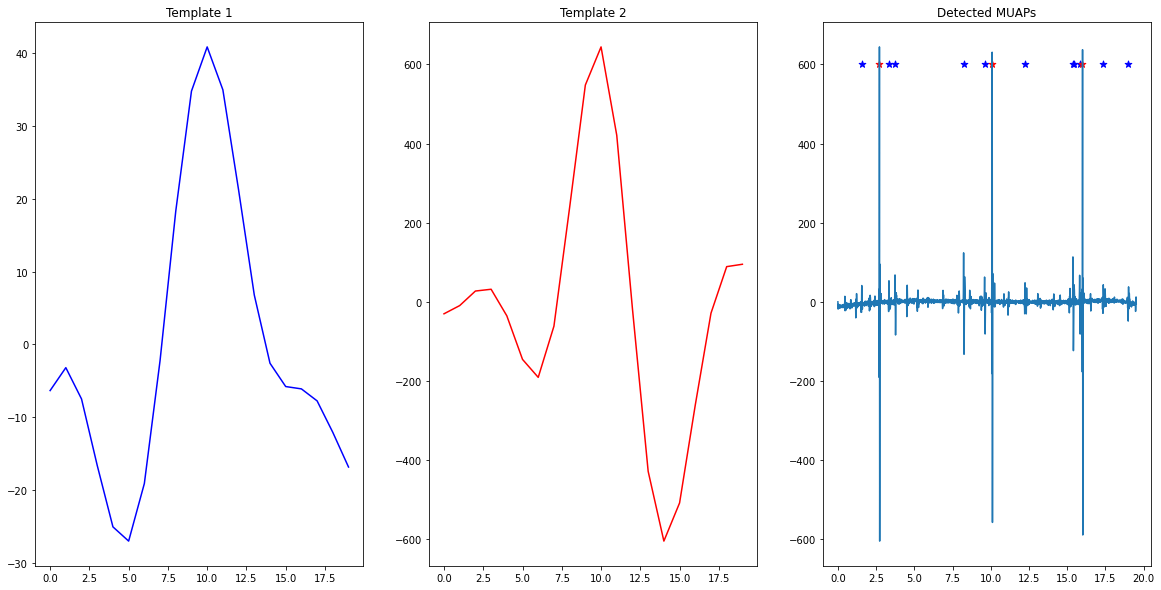

In [ ]:
peaks, templates = EMG_Decomposition(xaxis, 20)
print(peaks)
print(templates)